## EE 502 P: Analytical Methods for Electrical Engineering
    
# Homework 10: Review
## Due 15 December, 2019 at 11:59 PM

Copyright &copy; 2019, University of Washington

### <span style="color: red">Nidhin Mulangattil Sudhakaran</span>

# Fourier Meets Neural Networks

An approximation to a Fourier Series can be cast as a neural network where the input is a single number, which then fans out a number of neurons that output $\sin(2 \pi k x)$ and $\cos(2 \pi k x)$, for $k = 0 \dots n-1$. Those neurons are then multiplied by weights and summed together, which can be accomplished with a fully connected layer with $2n$ inputs and one output. Graphically, this looks like the following:

<img src="https://raw.githubusercontent.com/klavins/EE502P/master/images/fourier-network.jpeg" width=60%>

a) Write a `pytorch` model whose weights form the coefficients of a Fourier Series. The number of terms in the series should be an input to the constructor. Initially, the weights should be random. 

b) Create a `make_data` function that returns a square wave evaluated on a random list of numbers between 0 and 1. You will use this to train and evaluate your network. 

c) Use `MSELoss` and the `Adam` optimizer to learn the weights for the model so that it approximates the square wave using $n$ equal to $10$, $20$ and then $100$. How close are the learned weights to the optimal weights?

d) Repeat the problem, but instead of using sines and cosines, use a sum of $n$ radial basis functions. That is, approximate the function by

$$
\hat f(x) = \sum_{i=1}^n r \left (x-\frac{i}{n} \right )
$$

where 

$$
r(x) = e^{-ax^2}
$$

and $a = 100$. 

Notes: You will need to understand `pytorch` tensors fairly well before attempting this problem. This [tutorial](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py) and these [docs](https://pytorch.org/docs/stable/tensors.html) are indispensable. 

__a)__

In [1]:
# Import and Setup Libraries
import math
import numpy as np
import sympy as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from tqdm import tqdm
plt.style.use('ggplot')
%matplotlib inline

In [2]:
# Function that takes a real number x and an integer n,
# and returns a tensor with n Fourier basis terms (sine and cosine)
def fourier_basis(x,n):
    basis = []
    # Add n/2 sine terms to the list
    for i in range(int(n/2)):
        basis.append(np.sin(2*np.pi*i*x))
    # Add n/2 cosine terms to the list
    for i in range(int(n/2)):
        basis.append(np.cos(2*np.pi*i*x))
    # Typecast and return the tensor
    return torch.tensor(basis)

# Function that takes a real number x and an integer n,
# and returns a tensor with n radial basis terms
def radial_basis(x,n):
    # Calculate the list of n radial terms
    basis = [np.exp(-100*((x - ((i+1)/n))**2)) for i in range(n)]
    # Typecast and return the tensor
    return torch.tensor(basis)

# Pytorch model object
class ModelF(nn.Module):
    # The number of terms in basis function is an input to the constructor. 
    def __init__(self, terms):
        # Initialize the model
        super(ModelF, self).__init__()
        # Single linear layer whose weights form the coefficients of a basis function.
        self.fc1 = nn.Linear(terms, 1)
        
    def forward(self, x):
        # Linear activation function required for synthesis.
        x = self.fc1(x)
        return x

__b)__

In [3]:
# Function that takes an input x and returns a square wave evaluated on x
def make_data(n, basis_func, x = None):
    # If no x specified, use random numbers between 0 and 1
    if x == None:
        x = (np.random.rand(1,)[0])
    
    # Based on the basis selected, generate a tensor containing n terms
    if basis_func   == 'Fourier':    
        basis = fourier_basis(x, n)
    elif basis_func == 'Radial':
        basis = radial_basis(x, n)
    # Raise exception for invalid basis    
    else:
        raise Exception('Unknown basis')
    
    # Evaluate the square wave output with edge at 1/2,
    # with peak values of 1 and -1
    y = torch.tensor(1 if (x<(1/2)) else -1,
                     dtype=torch.float)
    return x,basis,y

__c)__

In [4]:
# Function to show the synthesis of square wave
def show_predictions(model,terms, basis):
    
    # Prepare the plot
    fig,ax=plt.subplots(1,figsize=(8,5))
    
    # Numbers between 0 and 1 for the plot
    _x = np.linspace(0, 1, num=500)  
   
    # Use the make_data function to generate the basis terms 
    _data = [make_data(terms, basis, x=i) for i in _x]
    data = list(zip(*_data))
    xvalues = data[1]

    # Use the model to synthesize the square wave
    yvalues = [model(m).item() for m in xvalues]
    
    # Generate the plot and add titles and labels
    ax.plot(_x, yvalues)
    ax.set_title('Square Wave Approximation with Neural Network.'\
                 ' Basis = {}, Terms = {}'.format(basis,sp.latex(terms)))
    ax.set_xlabel("x")
    ax.set_ylabel("y")      
    plt.show()
    return None

# Function to train the neural network for the synthesis of square wave
def predict(no_of_terms, basis = 'Fourier',learning_rate = 0.001, out = 'plot'):

    # Use 2n terms for Fourier basis (n sine terms and n cosine terms)
    if basis   == 'Fourier':    
        terms = 2*no_of_terms
    # Use n terms for Radial basis
    elif basis == 'Radial':
        terms = no_of_terms
    # Raise exception for invalid basis    
    else:
        raise Exception('Unknown basis')
        
    # Generate the model for the given number of terms
    model = ModelF(terms)
    # Use the root mean square loss function 
    criterion = nn.MSELoss()
    # Use Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    data = []
    # 2000 learning cycles with different data. Uses tdqm for progress bar.
    for _ in tqdm(range(2000)):
        # Generate data for the given basis function and the number of terms.
        _, x,y = make_data(terms,basis)
        # 30 cycles with the same data 
        for _ in range(30):
            # Train with the given loss functions and optimizer
            optimizer.zero_grad()
            yhat = model(x)
            loss = criterion(yhat,y)
            data.append(loss)
            loss.backward() 
            optimizer.step()

    return_val = []           
    # If the output method is 'plot', show the synthesized square wave with the model
    if out == 'plot':      
        show_predictions(model, terms, basis)
        return_val = None
    # If the output method is 'params', return the model parameters     
    elif out == 'params':
        for param in model.parameters():
            return_val.append(param.data)
    # Raise exception for invalid output type    
    else:
        raise Exception('Unknown output type')        
    return return_val

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:32<00:00, 61.03it/s]


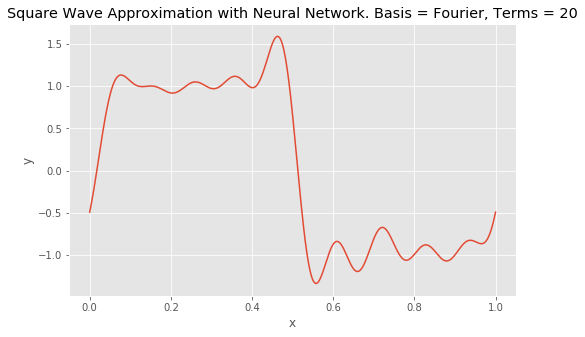

In [13]:
# Learn and synthesize square wave with 10 terms (10 sine, 10 cosine)
predict(10)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 64.25it/s]


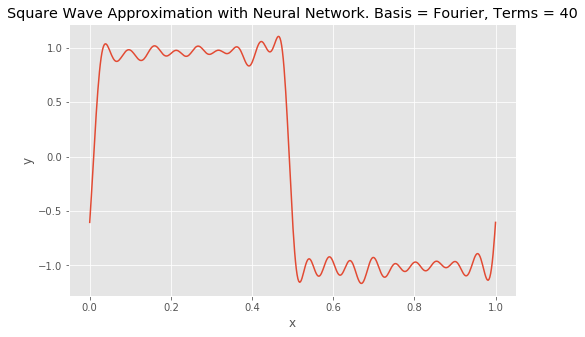

In [6]:
# Learn and synthesize square wave with 20 terms (20 sine, 20 cosine)
predict(20)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:33<00:00, 58.85it/s]


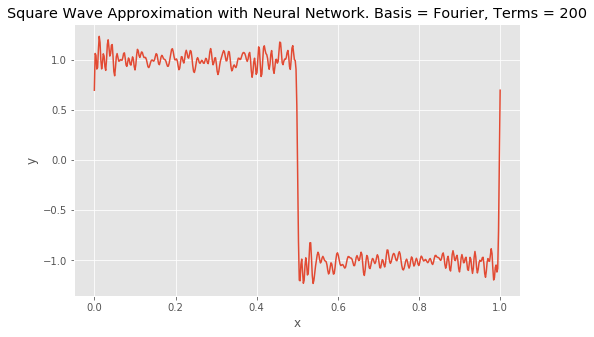

In [7]:
# Learn and synthesize square wave with 100 terms (100 sine, 100 cosine)
predict(100)

In [8]:
# Get the trained parameters for 20 terms
params = predict(20,out = 'params')

# Extract and print weights and bias
weights = (params[0].numpy())[0]
bias = (params[1].numpy())[0]
print(weights,bias)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:32<00:00, 62.11it/s]


[-1.55172497e-01  1.26309633e+00 -6.21484360e-03  4.01498258e-01
 -2.02990267e-02  2.51612157e-01 -1.34190200e-02  1.99067518e-01
  2.30039526e-02  1.46034449e-01 -9.84451617e-04  1.37182847e-01
 -1.80966198e-03  1.36195764e-01 -2.26054713e-03  1.21442236e-01
  1.16480710e-02  1.13292933e-01 -2.12987629e-03  7.61716142e-02
 -2.57520527e-02 -6.73964694e-02 -6.58905283e-02 -6.59827739e-02
 -5.15430570e-02 -5.82688376e-02 -4.83390801e-02 -5.93356825e-02
 -4.85004634e-02 -5.65711632e-02 -4.49884906e-02 -5.11623137e-02
 -4.79435585e-02 -3.81386317e-02 -2.45696772e-02 -4.10680212e-02
 -3.84521745e-02 -4.06689085e-02 -2.42445245e-02 -4.16534804e-02] -0.03995762


Note that weights of constants terms are almost balanced by the trained bias value. Although cosine and even sine terms should be zero, the neural network assigns values to them, contributing to the loss. Let's examine the weights of odd sine terms with respect to optimal (calculated) values.

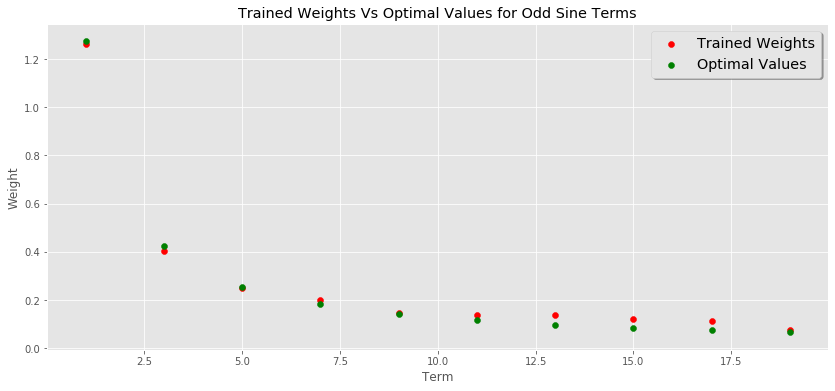

In [9]:
# Extract the weights of odd sine terms
odd_sines = [weights[i] for i in range(20) if (i%2 == 1)]

# Calculate the optimal values (actual Fourier coefficients)
opt_values = [(4/(i*np.pi)) for i in range(20) if (i%2 == 1)]

# Plot the weights and optimal values
fig, ax = plt.subplots(1,figsize=(14,6))
xvals = [i for i in range(20) if (i%2 == 1)]
ax.scatter(xvals, odd_sines,color='red', label='Trained Weights')
ax.scatter(xvals, opt_values,color='green', label='Optimal Values')

# Add labels, title and legend
ax.set_ylabel('Weight')
ax.set_xlabel('Term')
ax.set_title('Trained Weights Vs Optimal Values for Odd Sine Terms')
ax.legend(loc= 'upper right', shadow=True,fontsize='x-large')
plt.show()

As shown in the plot, the learned weights of odd sine terms (the non-zero terms in actual Fourier calculation) follows optimal values closely. 

__d)__

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 62.77it/s]


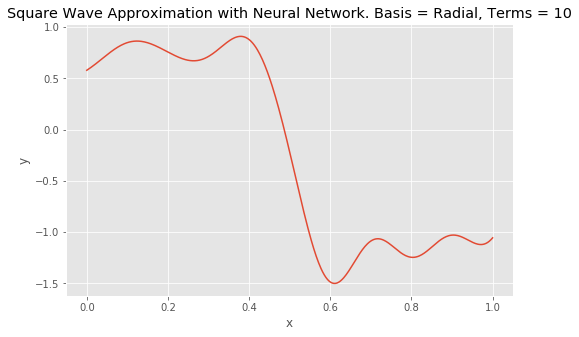

In [10]:
# Learn and synthesize square wave with radial basis and 10 terms
predict(10,basis = 'Radial')

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 63.24it/s]


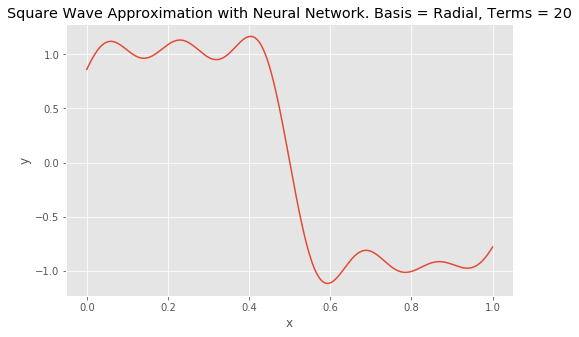

In [11]:
# Learn and synthesize square wave with radial basis and 20 terms
predict(20,basis = 'Radial')

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 63.16it/s]


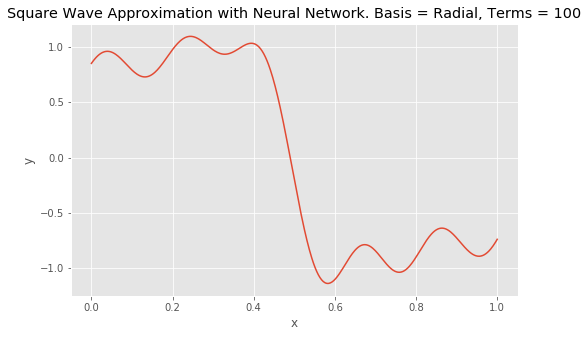

In [12]:
# Learn and synthesize square wave with radial basis and 100 terms
predict(100,basis = 'Radial')